# Classifying images for [AWS Rekognition](https://aws.amazon.com/rekognition/) DetectText

I've been using [AWS Rekognition](https://aws.amazon.com/rekognition/) to [detect text](https://docs.aws.amazon.com/rekognition/latest/dg/text-detection.html) written in images. AWS Rekognition charges every time I ask it to determine the text contained in an image even if the image doesn't contain any text.  If there was a way to determine that an image contains text before I attempt to call AWS Rekognition, I could reduce my costs.

When I started I didn't have any existing data or information about how many of the images contained text that could be recognized. I decided to call Rekognition on every image for the first month to create some data.  In that month I gathered results on 696,790 unique images.  Unique in this context means that the SHA256 and ResNet50 feature vectors differed.

## AWS Rekognition

AWS Rekognition provides a number of API's such as object detection, face detection but the function I'm using is [DetectText](https://docs.aws.amazon.com/rekognition/latest/dg/text-detection.html). This API method recognizes text inside of images larger than 80x80 pixels.  DetectText returns a list of detected words and lines of words. It also returns a confidence score about each detection.  This will be useful as I only want to consider highly confident and therefor accurate detections.

There are number of additional statistics that can be calculated on the results of AWS Rekognition.  The best way to view them is using a histogram from pandas but first lets get some basic statistics.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import os
import glob
import random
import matplotlib.image as mpimg
from matplotlib import colors
# All of the stats are stored in a file extracted from other data.
detection_results = pd.read_csv('image-stats.csv', index_col=False)
detection_results.describe()

width         height  highestConfidence  averageConfidence  \
count  696790.000000  696790.000000      696790.000000      696790.000000   
mean      706.078606     970.133987          67.529503          65.238553   
std       481.054533    4794.320173          45.166160          43.800297   
min       200.000000     200.000000           0.000000           0.000000   
25%       414.000000     338.000000           0.000000           0.000000   
50%       600.000000     480.000000          99.586811          93.078521   
75%       800.000000     770.000000          99.923378          98.902700   
max     20717.000000  630000.000000          99.996269          99.994743   

           lineCount  totalCharacters     totalWords  \
count  696790.000000    696790.000000  696790.000000   
mean        3.683913        49.103380       9.067022   
std         4.268154        68.515905      12.075720   
min         0.000000         0.000000       0.000000   
25%         0.000000         0.000000       0.000000   
50%         2.000000        20.000000       4.000000   
75%         6.000000        70.000000      13.000000   
max        44.000000       621.000000      84.000000   

       largestBoundingBoxPercentArea  totalBoundingBoxPercentArea  \
count                  696790.000000                696790.000000   
mean                        0.040971                     0.087795   
std                         0.071905                     0.123752   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.019228                     0.037484   
75%                         0.050838                     0.130500   
max                         1.560779                     1.922592   

       largestBoundingBoxPercentAreaAbove99Confidence  \
count                                   696790.000000   
mean                                         0.025804   
std                                          0.043815   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.007566   
75%                                          0.036027   
max                                          1.169616   

       totalBoundingBoxPercentAreaAbove99Confidence  \
count                                 696790.000000   
mean                                       0.050619   
std                                        0.080708   
min                                        0.000000   
25%                                        0.000000   
50%                                        0.009953   
75%                                        0.074217   
max                                        1.169616   

       totalCharactersAbove99Confidence  avgWordsPerLine  avgCharsPerLine  
count                     696790.000000    484688.000000    484688.000000  
mean                          26.822635         2.305343        12.318179  
std                           41.422876         1.335526         8.344943  
min                            0.000000         1.000000         1.000000  
25%                            0.000000         1.375000         7.000000  
50%                            7.000000         2.000000        10.750000  
75%                           39.000000         2.857143        15.666667  
max                          409.000000        20.000000       134.000000

There are outliers in width and height that should be dealt with as they will skew most of the histograms.

Lets see the histograms of the filtering by an iamge having a width of < 1000 and a height of < 1000.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128701790>,
      dtype=object)

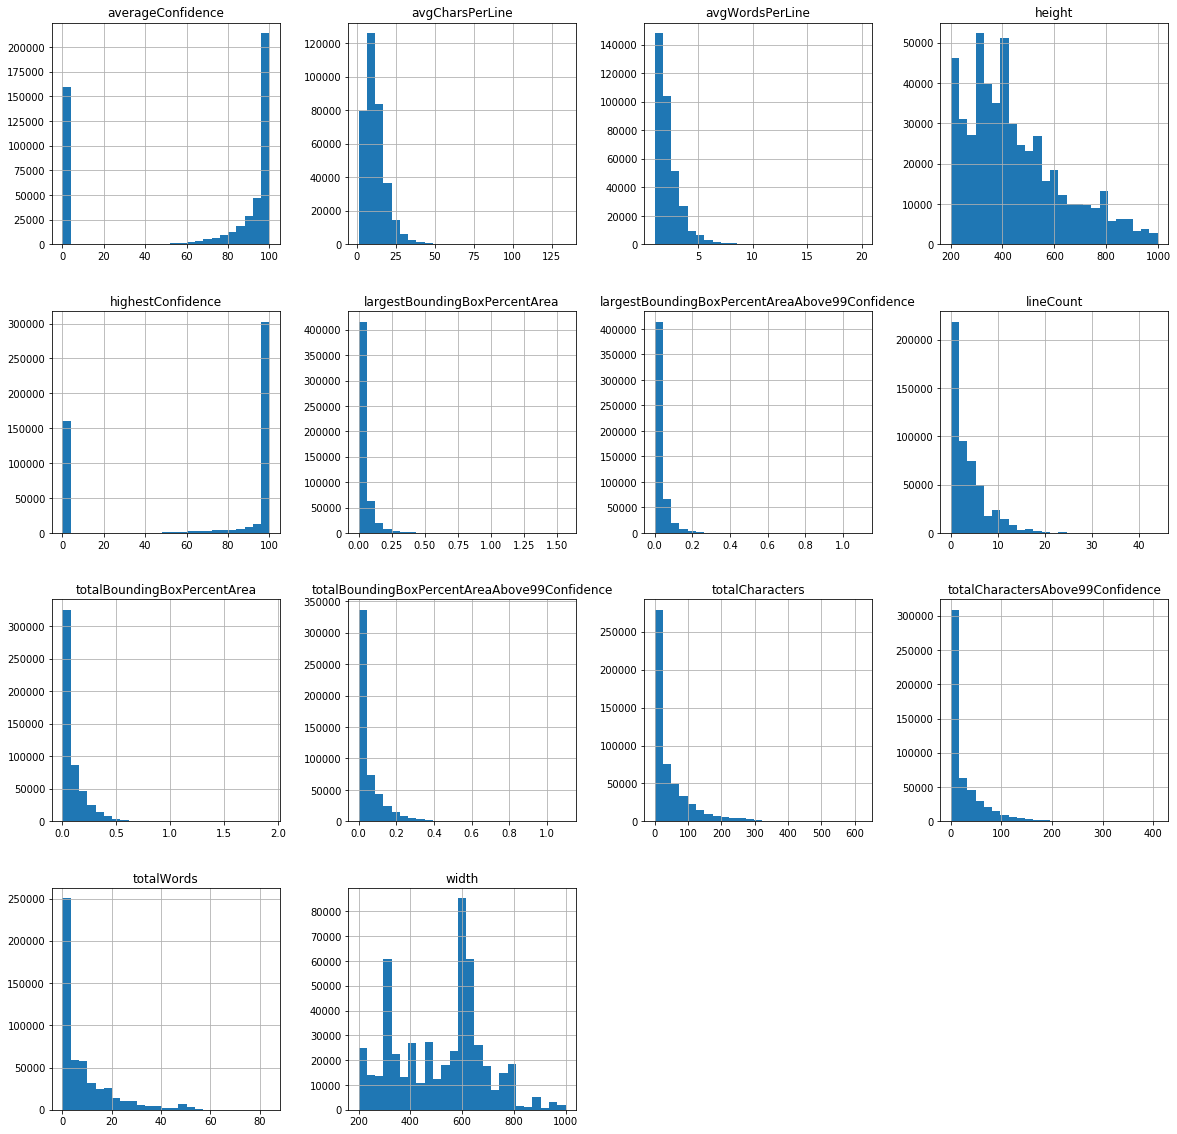

In [83]:
detection_results[(detection_results.width < 1000) & 
                 (detection_results.height < 1000)].hist(figsize=(20,20), bins=25)

A few interesting observations should be made about this data.

1. Bounding boxes can actually be larger than the source image size, if Rekognition detects text it may presume the bounding box is outside the image dimensions.  I believe this may help with truncated letters.

2. There supposedly a 50 word limit for DetectText, but that seems to have been exceeded.

In [12]:
# Break down the images into two classes.
# I'm interested in images that contain more than one with with more than five characters
# and have a highest confidence greater than 99%.
#
# You may have different desired thresholds.
#
has_text = detection_results[(
                            (detection_results.totalWords >1) &
                            (detection_results.totalCharacters > 5) &
                            (detection_results.highestConfidence >= 99))]

missing_text = detection_results[~(
                                (detection_results.totalWords >1) &
                                (detection_results.totalCharacters > 5) &
                                (detection_results.highestConfidence >= 99))]


In [27]:
# Show the statistics for images that contain text.
has_text.describe()

width         height  highestConfidence  averageConfidence  \
count  369610.000000  369610.000000      369610.000000      369610.000000   
mean      690.956879    1083.598057          99.850479          96.747887   
std       388.857577    5506.588818           0.173542           4.271304   
min       200.000000     200.000000          99.000031          62.853538   
25%       480.000000     349.000000          99.822655          95.620863   
50%       600.000000     500.000000          99.914970          98.578816   
75%       754.000000     800.000000          99.956688          99.543148   
max     20717.000000  630000.000000          99.996269          99.993210   

           lineCount  totalCharacters     totalWords  \
count  369610.000000    369610.000000  369610.000000   
mean        6.159541        85.833257      15.712705   
std         4.178277        72.919327      12.628358   
min         1.000000         6.000000       2.000000   
25%         3.000000        32.000000       6.000000   
50%         5.000000        63.000000      12.000000   
75%         8.000000       116.000000      21.000000   
max        44.000000       621.000000      84.000000   

       largestBoundingBoxPercentArea  totalBoundingBoxPercentArea  \
count                  369610.000000                369610.000000   
mean                        0.063066                     0.147209   
std                         0.067208                     0.124823   
min                         0.000000                     0.000000   
25%                         0.024465                     0.057853   
50%                         0.042368                     0.113231   
75%                         0.076491                     0.199701   
max                         1.326671                     1.890175   

       largestBoundingBoxPercentAreaAbove99Confidence  \
count                                   369610.000000   
mean                                         0.047557   
std                                          0.049252   
min                                          0.000000   
25%                                          0.018443   
50%                                          0.033428   
75%                                          0.058736   
max                                          1.116300   

       totalBoundingBoxPercentAreaAbove99Confidence  \
count                                 369610.000000   
mean                                       0.094334   
std                                        0.089575   
min                                        0.000000   
25%                                        0.031592   
50%                                        0.068624   
75%                                        0.127301   
max                                        1.116300   

       totalCharactersAbove99Confidence  avgWordsPerLine  avgCharsPerLine  
count                     369610.000000    369610.000000    369610.000000  
mean                          50.376391         2.541139        13.852195  
std                           45.297629         1.274785         7.719916  
min                            1.000000         1.000000         1.000000  
25%                           18.000000         1.666667         8.666667  
50%                           36.000000         2.250000        12.142857  
75%                           69.000000         3.000000        17.000000  
max                          409.000000        20.000000       113.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1267f0a10>,
      dtype=object)

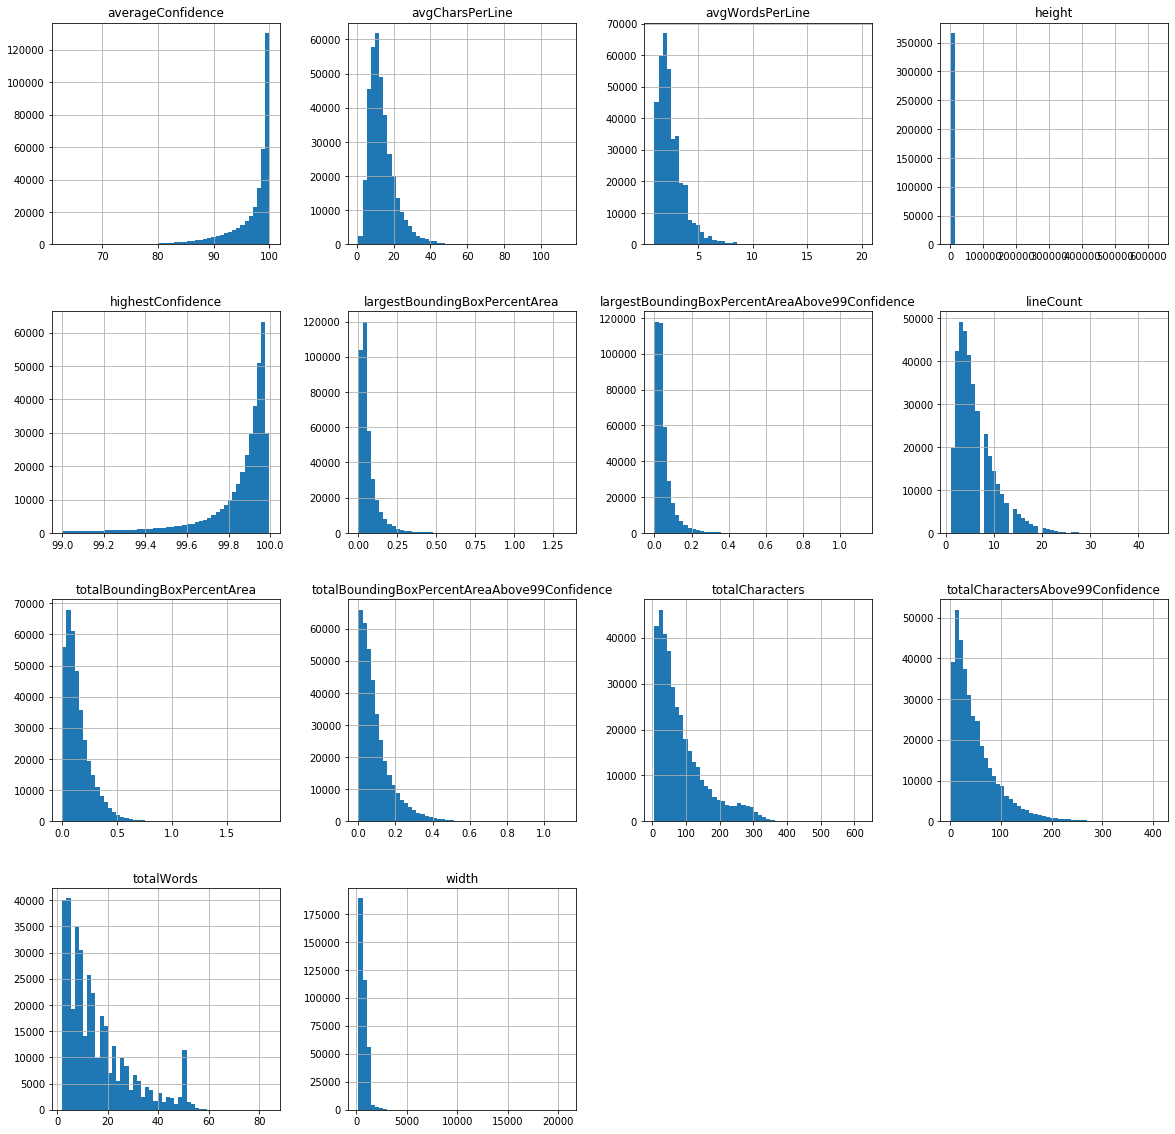

In [28]:
has_text.hist(figsize=(20,20), bins=50)

In [29]:
missing_text.describe()

width         height  highestConfidence  averageConfidence  \
count  327180.000000  327180.000000      327180.000000      327180.000000   
mean      723.161379     841.955447          31.017015          29.642964   
std       566.981819    3829.633422          42.792538          40.944796   
min       200.000000     200.000000           0.000000           0.000000   
25%       400.000000     324.000000           0.000000           0.000000   
50%       600.000000     450.000000           0.000000           0.000000   
75%       800.000000     740.000000          84.419479          78.068280   
max     16009.000000  442980.000000          99.994743          99.994743   

           lineCount  totalCharacters     totalWords  \
count  327180.000000    327180.000000  327180.000000   
mean        0.887236         7.610227       1.559499   
std         2.080817        27.297387       4.913727   
min         0.000000         0.000000       0.000000   
25%         0.000000         0.000000       0.000000   
50%         0.000000         0.000000       0.000000   
75%         1.000000         5.000000       1.000000   
max        43.000000       486.000000      80.000000   

       largestBoundingBoxPercentArea  totalBoundingBoxPercentArea  \
count                  327180.000000                327180.000000   
mean                        0.016011                     0.020675   
std                         0.068803                     0.080752   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         0.003545                     0.004720   
max                         1.560779                     1.922592   

       largestBoundingBoxPercentAreaAbove99Confidence  \
count                                   327180.000000   
mean                                         0.001231   
std                                          0.014481   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.169616   

       totalBoundingBoxPercentAreaAbove99Confidence  \
count                                 327180.000000   
mean                                       0.001235   
std                                        0.014508   
min                                        0.000000   
25%                                        0.000000   
50%                                        0.000000   
75%                                        0.000000   
max                                        1.169616   

       totalCharactersAbove99Confidence  avgWordsPerLine  avgCharsPerLine  
count                     327180.000000    115078.000000    115078.000000  
mean                           0.214335         1.548008         7.391193  
std                            1.237586         1.241269         8.369895  
min                            0.000000         1.000000         1.000000  
25%                            0.000000         1.000000         3.000000  
50%                            0.000000         1.000000         5.285714  
75%                            0.000000         1.666667         9.000000  
max                           25.000000        19.000000       134.000000

In [21]:
# Load and display some images with associated data.
def show_images(rows):
  images = []
  for index, img_path_record in rows.iterrows():
      images.append([mpimg.imread(img_path_record['img_filename']), img_path_record])

  plt.figure(figsize=(20,40))
  plt.axis('off')
  columns = 4
  for i, record in enumerate(images):
      image = record[0]
      info = record[1]
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.axis('off')
      plt.title("Confidence: {}, Words: {}, Chars: {}".format(round(info['highestConfidence'],2), info['totalWords'], info['totalCharacters']))
      plt.imshow(image)

### Examples that should be sent to Rekognition

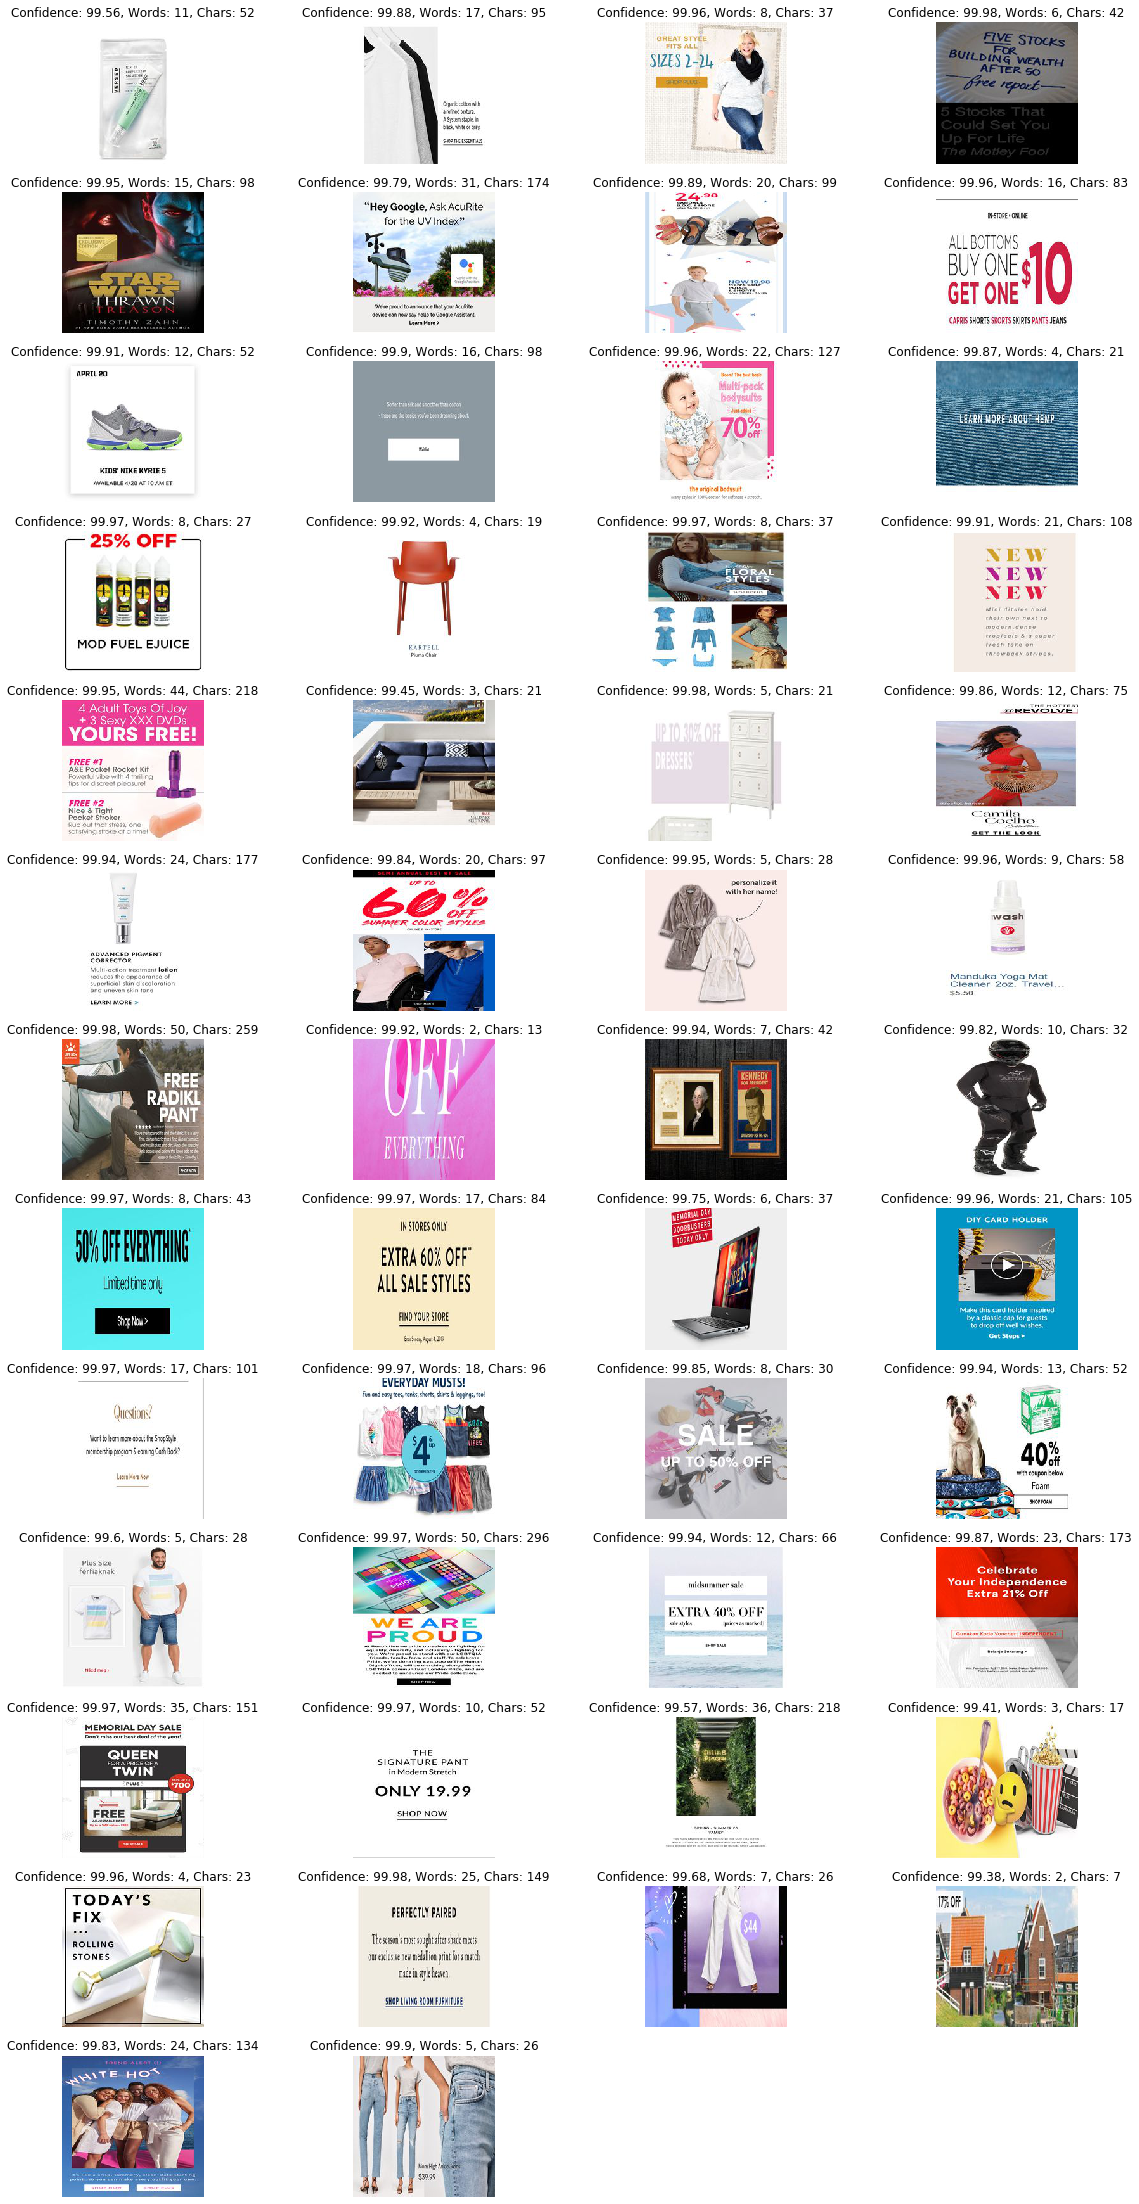

In [22]:
show_images( has_text.sample(frac=1)[0:50])

## Example images that shouldn't be sent to Rekognition

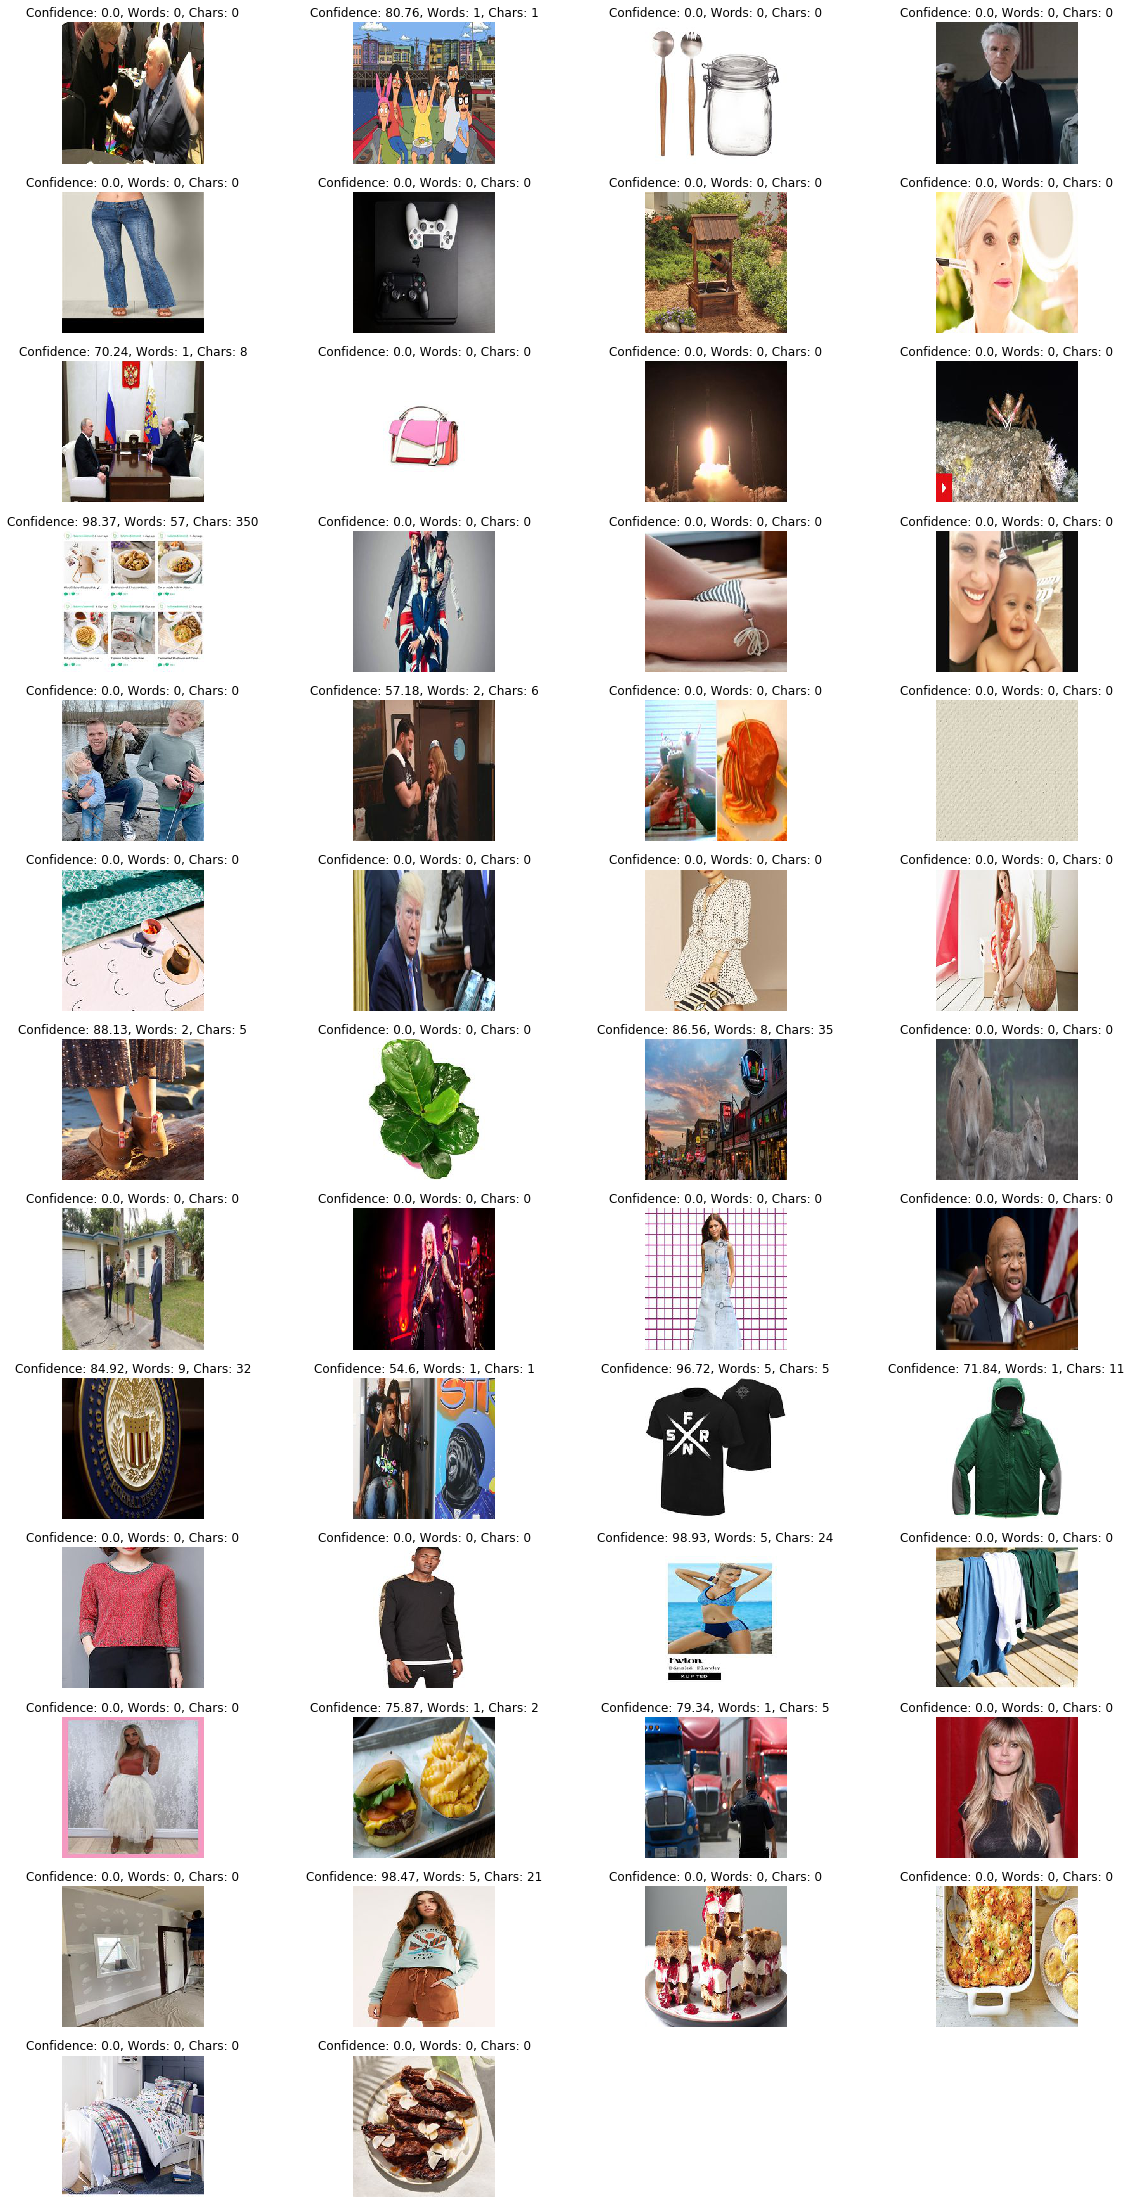

In [31]:
show_images(missing_text.sample(frac=1)[0:50])

## Classifier Criteria

Now that the images have been split into two classes, one which should be sent to Rekognition and another that shouldn't.  The classes are roughly equal in size so there shouldn't be much of a class imbalance problem.

369610 images pass the classifier and 327180 do not pass the classifier.  ~53% pass and ~47% don't pass.  


## Classifier Construction

To create the classifier I tried a few machine learning techniques from the laziest to the least lazy:

1. **Transfer learning.** Use the lower layers of an existing convolutional neural network (CNN) (i.e. ResNet50) and add additional layers.  This yielded an accuracy of 86% on a smaller extracted test dataset.

2. **Transfer learning with a gradient boosted tree.** Convert the images to feature vectors using an existing CNN (i.e. ResNet50) then attempt use xgboost to create a gradient boosted tree.  This can is a bit like transfer learning and trees combined.  It yielded an accuracy of 88% on a smaller extracted test dataset.

3. **Train a convolutional neural network specially for this task.** This approach was most successful and will be explained in the rest of this document.

## Ingredients needed

For creating the classifier I will be using Tensorflow 2.0.  Lets start by importing all of the things that will be needed.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf 
import pickle
import pathlib
import math
import datetime
import os
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.metrics import precision_recall_curve

%matplotlib inline
sns.set(font_scale=2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

## Splitting up the data into training, test and validation sets.

All of the images are located in two directories, ./image-classifier-dataset/true and ./image-classifier-dataset/false respectively based on if the image passed the classification criteria.

I've chosen to split the data into training, test and validation sets.

The test set will be 10% of the data with validation being 1%.

This is a pretty liberal allocation but since I've trained the model multiple times I know that I'd rather use most of my data in the training set rather than the test set.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
import pathlib
import math
import datetime
import os
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve

sns.set(font_scale=2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

# The images have been saved to a directory structure that looks like
# image-classifier-dataset/
#      true/                 - Images that should pass the classifier
#      false/                - Images that should not pass the classifier
root = pathlib.Path('./image-classifier-dataset/')
all_image_paths = [str(path) for path in list(root.glob('*/*'))]
all_image_paths.sort()

# Create the integer labels for each image by looking at the parent directory
# name of the image.
#
# 0 will represent that the image should not pass the classifier
# 1 will represent that the image should pass the classifier
all_image_labels = [0 if pathlib.Path(path).parent.name == 'false' else 1
                    for path in all_image_paths]

# Determine the size of the test set
test_size = math.floor(len(all_image_paths)*0.10)

# Determine the size of the validation set.
validation_size = math.floor(len(all_image_paths)*0.01)

# For reproducable results.
RANDOM_SEED = 2019

training_all_image_paths, test_all_image_paths, training_all_image_labels, test_all_image_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=test_size, random_state=RANDOM_SEED)
training_all_image_paths, validation_all_image_paths, training_all_image_labels, validation_all_image_labels = train_test_split(
    training_all_image_paths, training_all_image_labels, test_size=validation_size, random_state=RANDOM_SEED)

print("Training size: {} Test size: {} Validation size: {}".format(
    len(training_all_image_paths),
    len(test_all_image_paths),
    len(validation_all_image_paths)))

# Save the contents of the test, training and validation sets.
pickle.dump(training_all_image_paths, open("training_image_paths.p", "wb"))
pickle.dump(test_all_image_paths, open("test_image_paths.p", "wb"))
pickle.dump(validation_all_image_paths, open("validation_image_paths.p", "wb"))

## Loading and processing the images

The images themselves have already been scaled to be the size of 224 by 224 pixels.  This dimension was convenient since it was the input dimension to the ResNet50 pretrained CNN which was used for the initial experiments with transfer learning.

Once the image has been loaded, the pixel values themselves are mapped from a range of 0-255 to a float that is zero centered and ranges from -1 to 1.  This is a very standard thing to do with Tensorflow when using images.

### Not using tf.record and caching pre-processing.

The Tensorflow documentation recommends that image pre-processing be performed once and cached to speed up the image pipeline.  I've found that the size needed to serialize all of the preprocessed images isn't reasonable.  

The hardware that I will be using to train this neural network offers multiple CPU cores, in my experience so far it seems that Tensorflow can adequately keep the GPU saturated with data while performing the image pipeline processing.

In [55]:
# Load the image, resize if necessary, then zero center and norm between -1 and 1.
# this is pretty standard for neural networks.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 127.5
    image -= 1.
    return image

# Creating tf.Datasets

To perform training we need to create a tf.Dataset that combines the image along with the actual expected label (or classification value 1 for true 0 for false).  

Additionally for training and validation the tf.Datasets should form batches of examples.  Batches are collections of images and labels at a fixed size which are used to adjust the gradients of the neural network.  For now I've chosen a batch size of 128 images, this means that the gradient for learning will be averaged over the results of 128 images before weights are adjusted.  Choosing a smaller batch size may allow more accuracy but does increase the necessary training time.

In [ ]:
# Determine the batch size for training.  How many images will be considered
# before adjusting the weights in the direction of the gradient.
BATCH_SIZE = 128

test_path_ds = tf.data.Dataset.from_tensor_slices(test_all_image_paths)
test_image_ds = test_path_ds.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(
    tf.cast(test_all_image_labels, tf.int8))

training_path_ds = tf.data.Dataset.from_tensor_slices(training_all_image_paths)
training_image_ds = training_path_ds.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
training_label_ds = tf.data.Dataset.from_tensor_slices(
    tf.cast(training_all_image_labels, tf.int8))

validation_path_ds = tf.data.Dataset.from_tensor_slices(
    validation_all_image_paths)
validation_image_ds = validation_path_ds.map(
    load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
validation_label_ds = tf.data.Dataset.from_tensor_slices(
    tf.cast(validation_all_image_labels, tf.int8))

validation_image_label_ds = tf.data.Dataset.zip(
    (validation_image_ds, validation_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

# Training neural nets benefit from being presented random batches, but shuffling
# all of the data could be very expensive in the aspect of time, so just shuffle
# 128 times the batch size.
training_image_label_ds = tf.data.Dataset.zip((training_image_ds, training_label_ds)).shuffle(
    buffer_size=BATCH_SIZE*128, reshuffle_each_iteration=True).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

validation_batches = validation_image_label_ds.batch(BATCH_SIZE)
test_batches = test_image_label_ds.batch(
    BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

## Neural Network Architecture

Deciding on the neural network architecture is a problem that doesn't have a clear path from start to finish. Choices need to be made about the number of layers, type of layers, the parameters of the layers, activation functions and the choice of optimizers which determine the learning rate schedule.

If the neural network has too many parameters it will result in overfitting of the training set, if it has too few it will not be able to learn the generic patterns effectively.  


In [57]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    layers.Conv2D(24, 3, padding='same', activation=layers.ELU(
        alpha=1.0), input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=layers.ELU(alpha=1.0)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 5, padding='same', activation=layers.ELU(alpha=1.0)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 7, padding='same', activation=layers.ELU(alpha=1.0)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, 5, padding='same', activation=layers.ELU(alpha=1.0)),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation=layers.ELU(alpha=1.0)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation=layers.ELU(alpha=1.0)),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=[
                       "accuracy"
                      ]
             )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 24)      672       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 24)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      13888     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)       

## Training

The model is now defined it is now time to train the network using the training set of the images.

I've chosen to only train for 7 epochs since in previous testing that was sufficient for the level of accuracy I needed.

In [ ]:
steps_per_epoch = (math.ceil(len(training_all_image_paths)/BATCH_SIZE))

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

checkpoint_path = "train.weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(training_image_label_ds,
          epochs=7,
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_batches,
          callbacks=[cp_callback, tensorboard_callback],
          )


model.save('train.h5')

## Evaluating Performance

The model is now trained on all of the data for 7 epochs it is now time to evaluate its performance against the set of test images and labels that the neural net was not trained on.

In [35]:
#y_true = test_all_image_labels
#y_scores = model.predict(test_batches)

import pickle
from sklearn.metrics import precision_recall_curve
y_true = pickle.load(open("actual-truth.p", "rb" ))
y_scores = pickle.load(open("predictions.p", "rb" ))
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

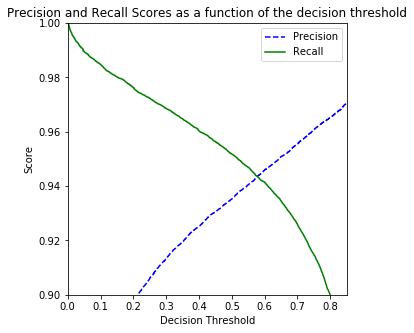

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(5, 5))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.ylim([0.90, 1.0])
    plt.xlim([0.00, 0.85])
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(precision, recall, thresholds)

# Choosing the threshold value

The output of the neural network is a probability between 0 and 1 that indicates that is interpreted as the probability that the image passed the classification criteria.  The probability is continuous between 0 and 1 but all of the test data is labeled 0 or 1. A threshold value must be chosen that converts the probability into 0 or 1 values, for example if the threshold was 0.5 it would mean if the probability if greater than or equal to 0.5 the output will be considered to be 1 otherwise the value is 0.  

The choice of the threshold should be driven by the desired performance of the neural network with regards to precision and recall. If the threshold is chosen to be a high number such as 0.90 it requires the neural network to produce a high probability for images to pass, this may result in images that would match the criteria be classified as not matching the criteria.  This is known as a false positive.  

As a counterpoint if the threshold is too low it means that images will be determined to have passed the criteria when in reality they do now.  This in turn means that more calls to AWS Rekognition will be made than necessary.  But it means that there will be a smaller number of images that will be false positives.

The choice of the threshold is a tradeoff between there opposing situations.  

I'd like to minimize false negatives while not sacrificing overall accuracy.  I'd like to have recall value >= 0.95.  As such I have chosen a threshold value of: 0.4325.

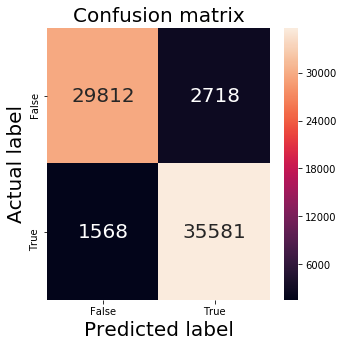

Precision: % 0.9164463572087304
Recall: % 0.950031867431485
Accuracy: % 0.9384893583432599
Error Rate: % 0.061510641656740195


In [54]:
from sklearn import metrics
import seaborn as sns 

THRESHOLD = 0.4325
LABELS = ['False', 'True'] 

max_test = y_true
max_predictions = [1 if pred >= THRESHOLD else 0 for pred in y_scores]
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('Actual label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)

precision = values[0][0]/(values[0][0]+values[0][1])
recall = values[0][0]/(values[0][0]+values[1][0])
print("Precision: %", precision)
print("Recall: %", recall)
print("Accuracy: %", 1 - (error_count/len(y_true)))
print("Error Rate: %", error_count/len(y_true))

## So what does this mean?

This means that the model will only have about a ~5% false positive rate.  Meaning it will not send images to Rekognition 5% of the time that it should.  On the other hand it will be accurate 91.6% of the time when it does send images to Rekognition.

How would have this performed on the first dataset?

In [81]:
total_images = (len(missing_text) + len(has_text))
true_text_percentage = len(has_text) / (len(missing_text) + len(has_text))
false_text_percentage = len(missing_text) / (len(missing_text) + len(has_text))

# The base percentage of the population, plus the percentage of false positives, subtracting the rate of false negatives.
total_call_percentage = true_text_percentage + (1-precision) - (1 - recall)
predicted_calls = math.ceil(total_call_percentage * total_images)
print("Predicted calls to Rekognition: {}, predicted Rekognition calls saved: {}".format(predicted_calls, total_images-predicted_calls))
print("Savings rate: {}% of unnecessary calls".format(round((total_images-predicted_calls)/total_images*100, 2)))
print("Actual false rate: {}%".format(round(false_text_percentage*100, 2)))

Predicted calls to Rekognition: 393013, predicted Rekognition calls saved: 303777
Savings rate: 43.6% of unnecessary calls
Actual false rate: 46.96%


## Model Benefits

The model will have about 43.6% of calls to Rekognition, which is better than having no model and making all calls. The test set has a rate of 46.96% of images without text, so this is an acceptable level of performance to me.

## Saving the model for [Tensorflow serving](https://github.com/tensorflow/serving)

Now that the model has been trained and the threshold has been selected.  The model should be saved so that it can be used by [Tensorflow serving](https://github.com/tensorflow/serving) to process requests.

The code below will load the model from ``train.h5`` and then save it in a directory called ``text-detect`` as version 1 of the model.  If there were multiple versions of the same model you could increment the version number.

In [ ]:
import keras.backend.tensorflow_backend as K
K.set_session

model = tf.keras.models.load_model(
    'train.h5', custom_objects={'ELU': tf.keras.layers.ELU})

tf.keras.experimental.export_saved_model(
    model, './text-detect/1', custom_objects={'ELU': tf.keras.layers.ELU})

## Setting up Tensorflow Serving

There is some configuration for Tensorflow serving to work with multple models.  I've added the text detection model such that my model.conf looks like this.

In [ ]:
model_config_list: {
  config: {
    name: "resnet50",
    base_path: "/models/resnet50",
    model_platform: "tensorflow"
  },
  config: {
    name: "xception",
    base_path: "/models/xception",
    model_platform: "tensorflow"
  },
  config: {
    name: "text-detect",
    base_path: "/models/text-detect",
    model_platform: "tensorflow"
  }
}

Next start the Tensorflow serving docker container like this.

In [ ]:
#!/bin/bash
export MODELDIR=[FILL IN WITH YOUR MODEL DIR]
docker run  --rm \
    -p 8501:8501 \
    -v "$MODELDIR/resnet-classifier:/models/resnet50" \
    -v "$MODELDIR/xception-classifier:/models/xception" \
    -v "$MODELDIR/text-detect:/models/text-detect" \
    -v "$MODELDIR/model.config:/model.config" tensorflow/serving --enable_batching --model_config_file=/model.config

## Building a Flask server to process requests.

Typically the code I write isn't going to talk to Tensorflow serving directly so I implement a flask app that performs the call after reshaping and scaling the image as needed.

In [ ]:
from __future__ import print_function
from flask import Flask, request

import base64
import requests
import logging
import sys
import json
import numpy as np

from keras.preprocessing import image

TEXT_DETECT_SERVER_URL = 'http://localhost:8501/v1/models/text-detect:predict'
app = Flask(__name__)
app.debug = True

# Accept requests to detect text, the image should be in the post body
@app.route("/text-detect", methods=['POST'])
def text_detect():
    if 'file' not in request.files:
        return 'No file passed', 500
    file = request.files['file']

    img = image.load_img(file, target_size=(224, 224))
    x = image.img_to_array(img)
    x /= 127.5
    x -= 1.

    payload = {
        "signature_name": "serving_default",
        "instances": [x.tolist()]
    }

    response = requests.post(TEXT_DETECT_SERVER_URL, json=payload)
    response.raise_for_status()

    # Note the use of the threshold value.
    final = {
        "result": response.json()['predictions'][0][0],
        "assessed": True if response.json()['predictions'][0][0] > 0.4325 else False,
        "version": "2019092101",
        "model": "text-detect"
    }
    return json.dumps(final), 200

if __name__ == '__main__':
    app.run('0.0.0.0', port=5000, debug=True)

## Testing the Flask app and model

The application can be tested just by using curl an example is below.

In [ ]:
#curl  -X POST -F file=@t-eb78obUHYcZFxkITDCqmWyaHvOB2NMYAk6Ctyq7ZqOM.jpg http://localhost:5000/text-detect 
{"result": 0.997018, "assessed": true, "version": "2019092101", "model": "text-detect"}